- Compare HSI emissions with Climate TRACE inventory and available literatural observation results

In [1]:
import os
from glob import glob
from itertools import chain
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import string
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import leafmap.foliumap as leafmap

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
# --- summary data ---
df_summary = pd.read_csv('../data/landfills_hyper_summary.csv', dtype={'metadata_report_year': str})
# units: t/h
# df_summary['emission'] = df_summary['emission']
# convert units from t/yr to t/h
df_summary['emissions_quantity'] /= (365*24)

# --- climate trace top 20 ---
df_climatetrace = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'metadata_report_year': str}, sheet_name='ClimateTrace_TOP20')
# convert units from t/yr to t/h
df_climatetrace['emissions_quantity'] /= (365*24)

# --- all HSI plume OBS ---
df_hyper_top20 = pd.read_excel('../data/landfills_hyper_obs.xlsx', sheet_name='ClimateTrace_TOP20')
# remove space at end
df_hyper_top20['name'] = df_hyper_top20['name'].str.strip()

# --- ground OBS data ---
df_obs = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'year': str}, sheet_name='OBS')
# units:t/h
df_obs['emission_obs'] = df_obs['emission(t/h)'] #/ 1e3 * 365 *24
df_obs['uncertainty_obs'] = df_obs['uncertainty(t/h)'] #/ 1e3 * 365 *24

# --- city emission ---
df_city = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'year': str}, sheet_name='Country_City')
# convert units from t/yr to t/h
df_city['ClimateTrace'] /= (365*24)
df_city['ClimateTrace_total'] /= (365*24)
df_city['WasteMAP'] /= (365*24)


## Overview Folium Map

In [4]:
m = leafmap.Map()
m.add_basemap("Esri.WorldImagery")

# m.add_circle_markers_from_xy(geo_df_large, x="lon", y="lat", radius=5, color="none", fill_color='blue', fill_opacity=0.6, popup=['lon', 'lat', 'emissions_quantity', 'asset_name', 'iso3_country', 'start_time', 'end_time'])
m.add_circle_markers_from_xy(df_summary[['longitude', 'latitude', 'name']].dropna(), x="longitude", y="latitude", radius=5, color="none", fill_color='blue', fill_opacity=0.6,
                             popup=['longitude', 'latitude', 'name'],
                             max_width=500)

In [5]:
m.to_html('../figures/hyper.html')

## Merge HSI and Climate TRACE data

In [14]:
df_merge = df_summary.groupby(['country', 'name'], as_index=False)\
                     .agg({'emission':'mean', 'emission_uncertainty(%)': 'mean',
                           'emissions_quantity': 'mean',
                           'emissions_factor':'mean', 'capacity':'mean', 'activity':'mean', 'plume_count': 'sum',
                           'metadata_source': 'first', 'metadata_report_year': 'first',
                           })

# calculate uncertainty
df_merge['emission_uncertainty(t/h)'] = df_merge['emission']*df_merge['emission_uncertainty(%)']*1e-2

# only keep row which has climate trace data
df_merge_ct = df_merge.dropna(subset=['emissions_quantity'])

# rename column names
df_merge_ct = df_merge_ct[['country', 'name', 'emission', 'emissions_quantity', 'emission_uncertainty(t/h)',
                           'plume_count', 'metadata_source', 'metadata_report_year',
                           ]]\
      .rename(columns={'country': 'Country', 'name': 'Name', 'emission': 'HSI', 'emission_uncertainty(t/h)': 'HSI uncertainty (t h$^{-1}$)',
                       'emissions_quantity': 'Climate TRACE', 'metadata_source': 'Report Source', 'metadata_report_year': 'Report Year'})
df_merge_ct['Report Year'] = df_merge_ct['Report Year'].str.rstrip('.0')

In [7]:
# df_merge_ct['HSI/ClimateTRACE'] = ((df_merge_ct['HSI']-df_merge_ct['Climate TRACE'])/df_merge_ct['Climate TRACE']).round(1)
df_merge_ct['HSI/ClimateTRACE'] = (df_merge_ct['HSI']/df_merge_ct['Climate TRACE']).round(1)

In [8]:
df_2021_2022 = df_merge_ct[df_merge_ct['Report Year'].isin(['2021', '2022'])]
# df_2021_2022['HSI'].sum() / df_2021_2022['Climate TRACE'].sum()
(df_2021_2022['HSI'].sum() - df_2021_2022['Climate TRACE'].sum()) / df_2021_2022['Climate TRACE'].sum()

1.3004922830633432

In [9]:
df_merge_ct['HSI/ClimateTRACE'].median(), df_2021_2022['HSI/ClimateTRACE'].median()

(2.45, 4.7)

In [10]:
df_merge_ct.sort_values('HSI/ClimateTRACE', ascending=False)

,Country,Name,HSI,Climate TRACE,HSI uncertainty (t h$^{-1}$),plume_count,Report Source,Report Year,HSI/ClimateTRACE
7,India,Bandhwari,2.397993,0.015812,0.823099,4,Global Plastic Watch,2021,151.7
13,India,Majura,6.859796,0.173664,2.119944,3,Global Plastic Watch,2021,39.5
12,India,Kanjurmarg,8.321277,0.442059,2.678272,4,Global Plastic Watch,2021,18.8
14,India,Manter Wadi,3.688931,0.283659,1.463190,1,Global Plastic Watch,2021,13.0
11,India,Kachara,3.760001,0.349474,1.542553,1,Global Plastic Watch,2021,10.8
1,Argentina,Norte III,22.011851,3.256637,6.433543,8,Waste Atlas,2013,6.8
34,United States,Charlotte Motor Speedway,4.850443,0.733782,2.027601,3,EPA GHGRP,2021,6.6
31,Saudi Arabia,Riyadh,11.969482,1.877095,3.415541,11,METER/OSM,2022,6.4
23,Kuwait,Kabd,7.129995,1.526076,2.145553,10,METER/OSM,2022,4.7
32,Spain,Pinto,7.139583,1.552511,2.499697,1,E-PRTR,2021,4.6


In [11]:
df_merge_ct_format = df_merge_ct.round(decimals=1)
df_merge_ct_format['HSI'] = df_merge_ct_format['HSI'].astype(str) + ' $\pm$ ' + df_merge_ct_format['HSI uncertainty (t h$^{-1}$)'].astype(str)
# # print latex table
print(df_merge_ct_format.drop(['plume_count', 'HSI uncertainty (t h$^{-1}$)', 'HSI/ClimateTRACE'], axis=1).to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{lllrll}
\toprule
Country & Name & HSI & Climate TRACE & Report Source & Report Year \\
\midrule
Argentina & González Catán & 2.8 $\pm$ 0.9 &        2.2 & Waste Atlas & 2013 \\
Argentina & Norte III & 22.0 $\pm$ 6.4 &        3.3 & Waste Atlas & 2013 \\
Argentina & Piedra Blanca & 3.3 $\pm$ 1.3 &        1.7 & METER/OSM & 2022 \\
Bangladesh & Aminbazar & 4.1 $\pm$ 1.6 &        1.5 & METER/OSM & 2022 \\
India & Bandhwari & 2.4 $\pm$ 0.8 &        0.0 & Global Plastic Watch & 2021 \\
India & Bhalswa & 2.2 $\pm$ 0.8 &        1.4 & Waste Atlas & 2013 \\
India & Deonar & 2.2 $\pm$ 0.9 &        2.4 & Waste Atlas & 2013 \\
India & Ghazipur & 4.0 $\pm$ 1.3 &        2.0 & Waste Atlas & 2013 \\
India & Kachara & 3.8 $\pm$ 1.5 &        0.3 & Global Plastic Watch & 2021 \\
India & Kanjurmarg & 8.3 $\pm$ 2.7 &        0.4 & Global Plastic Watch & 2021 \\
India & Majura & 6.9 $\pm$ 2.1 &        0.2 & Global Plastic Watch & 2021 \\
India & Manter Wadi & 3.7 $\pm$ 1.5 &        0.3 & Global 

In [12]:
# # print latex table
# print(df_merge_ct.rename(columns={'HSI': 'HSI (t h$^{-1}$)', 'Climate TRACE': 'Climate TRACE (t h$^{-1}$)'}).to_latex(index=False, float_format=lambda x: '%10.1f' % x))

In [13]:
# total emission t h-1
df_merge_ct['HSI'].sum()

141.06916376193692

In [14]:
# uncertainty of total emission
np.sqrt(((df_merge_ct['HSI uncertainty (t h$^{-1}$)'])**2).sum())

11.11641099613772

In [15]:
df_merge_ct['HSI'].sum()/df_merge_ct['Climate TRACE'].sum()

1.8004548154216484

In [16]:
# the total HSI emission is ??% higher than inventory
(df_merge_ct['HSI'].sum() - df_merge_ct['Climate TRACE'].sum())/df_merge_ct['Climate TRACE'].sum()

0.8004548154216484

## Fit HSI and Climate TRACE

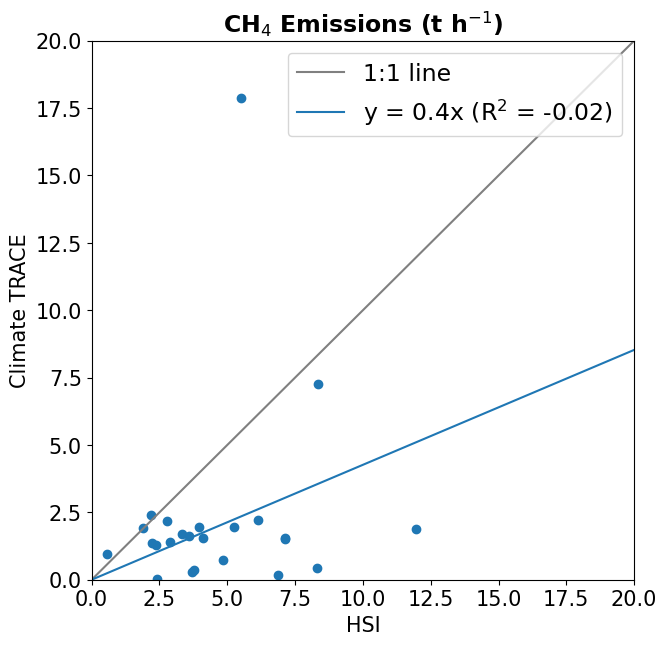

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))

x = df_merge_ct['HSI'].values
xerr = df_merge_ct['HSI uncertainty (t h$^{-1}$)']
y = df_merge_ct['Climate TRACE'].values

# Reshape the arrays to 2D
x_2d = x.reshape(-1, 1)
y_2d = y.reshape(-1, 1)

# Create and fit the linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(x_2d, y_2d)

# Get the slope of the linear regression line
slope = model.coef_[0][0]

# Calculate R-squared
r_squared = model.score(x_2d, y_2d)

plt.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='gray')
plt.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0')

ax.scatter(x, y)

ax.set_xlabel('HSI')
ax.set_ylabel('Climate TRACE')
ax.set_title('CH$_4$ Emissions (t h$^{-1}$)')

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)

plt.legend()

# fig.savefig('../figures/hsi_climatetrace_fit.pdf')

## Matrix plot

In [18]:
def plot_stats(df):
    # https://stackoverflow.com/a/50690729/7347925
    def corrdot(*args, **kwargs):
        corr_r = args[0].corr(args[1], 'pearson')
        corr_text = f"{corr_r:2.2f}".replace("0.", ".")
        ax = plt.gca()
        ax.set_axis_off()
        marker_size = abs(corr_r) * 10000
        ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
                vmin=-1, vmax=1, transform=ax.transAxes)
        font_size = abs(corr_r) * 40 + 5
        ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                    ha='center', va='center', fontsize=font_size)

    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_upper(corrdot)

In [19]:
# plot_stats(df_merge[['emission', 'emissions_quantity', 'emissions_factor', 'capacity', 'activity']])

## City emission

In [20]:
def calc_city_emiss(row, df_merge):
    if pd.notna(row['landfills']):
        names = [name.lstrip() for name in row['landfills'].split(',')]
        df_city_subset = df_merge[df_merge['name'].isin(names)]
        emiss_mean = df_city_subset['emission'].sum().item()
        emiss_std = np.sqrt((df_city_subset['emission_uncertainty(t/h)']**2).sum()).item()
        return emiss_mean, emiss_std
    else:
        return np.nan, np.nan

In [21]:
df_city['HSI'], df_city['HSI uncertainty'] = zip(*df_city.apply(calc_city_emiss, args=(df_merge,), axis=1))

In [22]:
df_merge

,country,name,emission,emission_uncertainty(%),emissions_quantity,emissions_factor,capacity,activity,plume_count,metadata_source,metadata_report_year,emission_uncertainty(t/h)
0,Argentina,González Catán,2.769783,34.109548,2.177970,0.041004,1200000.00,465297.85,5,Waste Atlas,2013.0,0.944760
1,Argentina,Norte III,22.011851,29.227634,3.256637,0.045643,900000.00,625026.97,8,Waste Atlas,2013.0,6.433543
2,Argentina,Piedra Blanca,3.347987,38.834970,1.701192,0.041850,NaN,356094.72,2,METER/OSM,2022.0,1.300190
3,Bangladesh,Aminbazar,4.092617,39.811138,1.541889,0.046725,NaN,289072.51,1,METER/OSM,2022.0,1.629317
4,Brazil,Caieiras,14.035058,34.313487,NaN,NaN,NaN,NaN,1,None,None,4.815918
5,Brazil,Pedreira,11.525591,34.654589,NaN,NaN,NaN,NaN,1,None,None,3.994146
6,China,Ürümqi,10.652942,41.183351,NaN,NaN,NaN,NaN,5,None,None,4.387238
7,India,Bandhwari,2.397993,34.324486,0.015812,0.054080,1361.51,2561.19,4,Global Plastic Watch,2021.0,0.823099
8,India,Bhalswa,2.214972,35.898002,1.377097,0.046983,161799.83,256761.58,6,Waste Atlas,2013.0,0.795131
9,India,Deonar,2.199969,42.919733,2.400635,0.053694,1325080.24,391657.52,2,Waste Atlas,2013.0,0.944221


In [23]:
df_city

,country,city,landfills,ClimateTrace,WasteMAP,ClimateTrace_total,ClimateTrace_num,coverage,HSI,HSI uncertainty
0,Argentina,All,"González Catán, Piedra Blanca, Norte III",60.283345,24.429224,60.283345,71.0,4.2,6.117770,1.607192
1,Argentina,Buenos Aires,"Norte III, González Catán",NaN,3.790068,NaN,NaN,NaN,24.781634,6.502542
2,Bangladesh,All,Aminbazar,24.487857,24.543379,1.541889,1.0,100.0,4.092617,1.629317
3,Bangladesh,Dhaka,Aminbazar,NaN,3.892009,NaN,NaN,NaN,4.092617,1.629317
4,Brazil,All,"Caieiras, Pedreira",247.759799,247.716895,205.275049,285.0,0.7,25.560648,6.256698
5,Brazil,São Paulo,"Caieiras, Pedreira",NaN,9.826712,NaN,NaN,NaN,25.560648,6.256698
6,China,All,Ürümqi,681.477749,681.506849,231.341607,592.0,0.2,10.652942,4.387238
7,India,All,"Bandhwari, Bhalswa, Deonar, Ghazipur, Kachara,...",108.917550,71.118721,108.917550,534.0,1.9,41.438584,5.015747
8,Iran,All,"Mashhad, Tehran",41.476894,16.438356,41.476894,42.0,4.8,11.499941,3.241336
9,Iran,Tehran,Tehran,NaN,1.911416,NaN,NaN,NaN,7.781694,2.837069


In [24]:
# add plume count to landfill name
for idx, landfill in enumerate(df_city['landfills']):
    if pd.notnull(landfill):
        landfill_names = landfill.split(',')#[0].strip()
        new_namelist = []
        for landfill_name in landfill_names:
            # print(landfill_name)
            new_name = landfill_name + ' ('+ str(df_merge.loc[df_merge['name'] == landfill_name.strip()]['plume_count'].item()) + ')'
            new_namelist.append(new_name)
        name_num = ','.join(new_namelist)
        df_city.loc[idx, 'landfills'] = name_num

In [25]:
df_country = df_city.groupby(['country'], as_index=False)\
    .agg({'HSI': lambda x: x.sum(min_count=1), 
          'ClimateTrace': 'max',
          'ClimateTrace_total': 'max',
          'WasteMAP': 'max',
        #   'HSI uncertainty': lambda x: np.sqrt(np.nansum(x**2)),
          'HSI uncertainty': lambda x: np.sqrt((x**2).sum(min_count=1)),
          })

In [26]:
df_country

,country,HSI,ClimateTrace,ClimateTrace_total,WasteMAP,HSI uncertainty
0,Argentina,30.899404,60.283345,60.283345,24.429224,6.698217
1,Bangladesh,8.185234,24.487857,1.541889,24.543379,2.304203
2,Brazil,51.121297,247.759799,205.275049,247.716895,8.848307
3,China,10.652942,681.477749,231.341607,681.506849,4.387238
4,India,41.438584,108.917550,108.917550,71.118721,5.015747
5,Iran,19.281635,41.476894,41.476894,16.438356,4.307577
6,Israel,11.370299,22.364848,2.693782,22.374429,2.745100
7,Jordan,20.300220,15.978632,12.282878,15.981735,3.636291
8,Kuwait,14.259991,36.672657,14.077345,36.643836,3.034270
9,Mexico,47.442411,476.626099,476.626099,222.374429,7.491114


In [27]:
# print latex table
df_city_subset = df_city[df_city['city']!='All'][['country', 'city', 'landfills', 'WasteMAP', 'HSI', 'HSI uncertainty']]\
      .rename(columns={'country': 'Country', 'city':'City', 'landfills': 'Landfills'})
df_city_subset['HSI/WasteMAP'] = np.round(df_city_subset['HSI']/df_city_subset['WasteMAP'], 1)

df_city_subset_format = df_city_subset.round(decimals=1)
df_city_subset_format['HSI'] = df_city_subset_format['HSI'].astype(str) + ' $\pm$ ' + df_city_subset_format['HSI uncertainty'].astype(str)
# # print latex table
print(df_city_subset_format.drop('HSI uncertainty', axis=1).rename(columns={'WasteMAP': 'WasteMAP (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)'}).to_latex(index=False, float_format=lambda x: '%10.1f' % x))

# print(df_city_subset.rename(columns={'WasteMAP': 'WasteMAP (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'HSI uncertainty': 'HSI uncertainty (t h$^{-1}$)'})\
#     .to_latex(index=False, float_format=lambda x: '%10.1f' % x)
#     )

\begin{tabular}{lllrlr}
\toprule
Country & City & Landfills & WasteMAP (t h$^{-1}$) & HSI (t h$^{-1}$) & HSI/WasteMAP \\
\midrule
Argentina & Buenos Aires & Norte III (8), González Catán (5) &        3.8 & 24.8 $\pm$ 6.5 &        6.5 \\
Bangladesh & Dhaka & Aminbazar (1) &        3.9 & 4.1 $\pm$ 1.6 &        1.1 \\
Brazil & São Paulo & Caieiras (1), Pedreira (1) &        9.8 & 25.6 $\pm$ 6.3 &        2.6 \\
Iran & Tehran & Tehran (9) &        1.9 & 7.8 $\pm$ 2.8 &        4.1 \\
Jordan & Amman & Ghabawi (14) &        1.1 & 8.4 $\pm$ 2.4 &        7.6 \\
Kuwait & Kuwait City & Kabd (10) &       10.0 & 7.1 $\pm$ 2.1 &        0.7 \\
Mexico & Mexico City & Zumpango (1), Relleno Sanitario Peña De Gatos (3), Relleno Sanitario Bicentenario (1), Tecnosilicatos (3) &       12.5 & 18.2 $\pm$ 4.8 &        1.5 \\
Mexico & Monterrey & Simeprodeso (5) &        0.3 & 5.5 $\pm$ 2.2 &       16.3 \\
Pakistan & Lahore & Lakhodair (2) &        6.0 & 12.0 $\pm$ 4.2 &        2.0 \\
Pakistan & Karachi & Jam Ch

In [28]:
# city emission > HSI or within 10%
df_city_subset['percent_diff'] = (df_city_subset['HSI']-df_city_subset['WasteMAP']) / df_city_subset['WasteMAP'] * 100
df_city_subset[(df_city_subset['percent_diff']<0) | (np.abs(df_city_subset['percent_diff'])<10)]

,Country,City,Landfills,WasteMAP,HSI,HSI uncertainty,HSI/WasteMAP,percent_diff
3,Bangladesh,Dhaka,Aminbazar (1),3.892009,4.092617,1.629317,1.1,5.154357
14,Kuwait,Kuwait City,Kabd (10),10.044406,7.129995,2.145553,0.7,-29.015263
20,Pakistan,Karachi,Jam Chakro (1),5.303539,5.237231,1.882055,1.0,-1.250253
22,Saudi Arabia,Riyadh,Riyadh (11),11.811644,11.969482,3.415541,1.0,1.336290
31,Yemen,Sanaa,Al-Azraqin (1),1.589155,0.582031,0.193089,0.4,-63.374820


In [29]:
df_city_subset['HSI/WasteMAP'].mean()

6.253333333333334

In [30]:
df_city_subset.sort_values('HSI/WasteMAP')

,Country,City,Landfills,WasteMAP,HSI,HSI uncertainty,HSI/WasteMAP,percent_diff
31,Yemen,Sanaa,Al-Azraqin (1),1.589155,0.582031,0.193089,0.4,-63.374820
14,Kuwait,Kuwait City,Kabd (10),10.044406,7.129995,2.145553,0.7,-29.015263
20,Pakistan,Karachi,Jam Chakro (1),5.303539,5.237231,1.882055,1.0,-1.250253
22,Saudi Arabia,Riyadh,Riyadh (11),11.811644,11.969482,3.415541,1.0,1.336290
3,Bangladesh,Dhaka,Aminbazar (1),3.892009,4.092617,1.629317,1.1,5.154357
16,Mexico,Mexico City,"Zumpango (1), Relleno Sanitario Peña De Gatos ...",12.502283,18.212903,4.840981,1.5,45.676615
19,Pakistan,Lahore,Lakhodair (2),5.994749,12.003628,4.182772,2.0,100.235717
5,Brazil,São Paulo,"Caieiras (1), Pedreira (1)",9.826712,25.560648,6.256698,2.6,160.113939
29,Uzbekistan,Tashkent,Akhangaran (8),0.935845,3.734796,1.385138,4.0,299.082859
9,Iran,Tehran,Tehran (9),1.911416,7.781694,2.837069,4.1,307.116816


In [31]:
df_country['HSI/ClimateTrace'] = df_country['HSI'] / df_country['ClimateTrace']
df_country['HSI/ClimateTrace(%)'] = df_country['HSI/ClimateTrace'] * 100
df_country['percent_diff'] = (df_country['HSI']-df_country['ClimateTrace']) / df_country['ClimateTrace'] * 100
df_country['percent_diff_facility_total'] = (df_country['ClimateTrace_total']-df_country['HSI']) / df_country['HSI'] * 100

In [32]:
# how much facility-level estimations lower than the country emissions
df_country[df_country['percent_diff_facility_total']<0]['percent_diff_facility_total'].mean()

-47.30226564419827

In [33]:
df_country.dropna(subset=['HSI', 'ClimateTrace']).sort_values('HSI/ClimateTrace')

,country,HSI,ClimateTrace,ClimateTrace_total,WasteMAP,HSI uncertainty,HSI/ClimateTrace,HSI/ClimateTrace(%),percent_diff,percent_diff_facility_total
14,United States,7.742997,690.356070,690.356070,414.269406,2.167406,0.011216,1.121595,-98.878405,8815.877222
3,China,10.652942,681.477749,231.341607,681.506849,4.387238,0.015632,1.563212,-98.436788,2071.621825
9,Mexico,47.442411,476.626099,476.626099,222.374429,7.491114,0.099538,9.953801,-90.046199,904.641391
16,Yemen,1.164062,11.331236,0.960326,11.301370,0.273069,0.102730,10.273036,-89.726964,-17.502115
2,Brazil,51.121297,247.759799,205.275049,247.716895,8.848307,0.206334,20.633411,-79.366589,301.545073
12,Spain,14.279166,52.487856,17.251027,56.621005,3.535105,0.272047,27.204704,-72.795296,20.812571
1,Bangladesh,8.185234,24.487857,1.541889,24.543379,2.304203,0.334257,33.425687,-66.574313,-81.162552
15,Uzbekistan,7.469592,21.065895,13.383096,21.118721,1.958881,0.354582,35.458223,-64.541777,79.167697
4,India,41.438584,108.917550,108.917550,71.118721,5.015747,0.380458,38.045828,-61.954172,162.840910
8,Kuwait,14.259991,36.672657,14.077345,36.643836,3.034270,0.388845,38.884531,-61.115469,-1.280829


In [34]:
df_country_format = df_country.round(decimals=1)
df_country_format['HSI'] = df_country_format['HSI'].astype(str) + ' $\pm$ ' + df_country_format['HSI uncertainty'].astype(str)
# # print latex table
print(df_country_format.drop('HSI uncertainty', axis=1)[['country', 'ClimateTrace', 'HSI', 'HSI/ClimateTrace(%)']].dropna(subset=['HSI', 'ClimateTrace'])\
      .rename(columns={'country': 'Country', 'ClimateTrace': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)'})\
        .to_latex(index=False, float_format=lambda x: '%10.1f' % x))
      

# print(df_country[['country', 'ClimateTrace', 'HSI', 'HSI uncertainty']].dropna(subset=['HSI', 'ClimateTrace'])\
#       .rename(columns={'country': 'Country', 'ClimateTrace': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'HSI uncertainty': 'HSI uncertainty (t h$^{-1}$)'})\
#         .to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{lrlr}
\toprule
Country & Climate TRACE (t h$^{-1}$) & HSI (t h$^{-1}$) & HSI/ClimateTrace(%) \\
\midrule
Argentina &       60.3 & 30.9 $\pm$ 6.7 &       51.3 \\
Bangladesh &       24.5 & 8.2 $\pm$ 2.3 &       33.4 \\
Brazil &      247.8 & 51.1 $\pm$ 8.8 &       20.6 \\
China &      681.5 & 10.7 $\pm$ 4.4 &        1.6 \\
India &      108.9 & 41.4 $\pm$ 5.0 &       38.0 \\
Iran &       41.5 & 19.3 $\pm$ 4.3 &       46.5 \\
Israel &       22.4 & 11.4 $\pm$ 2.7 &       50.8 \\
Jordan &       16.0 & 20.3 $\pm$ 3.6 &      127.0 \\
Kuwait &       36.7 & 14.3 $\pm$ 3.0 &       38.9 \\
Mexico &      476.6 & 47.4 $\pm$ 7.5 &       10.0 \\
Pakistan &       55.3 & 34.5 $\pm$ 6.5 &       62.4 \\
Saudi Arabia &       59.4 & 23.9 $\pm$ 4.8 &       40.3 \\
Spain &       52.5 & 14.3 $\pm$ 3.5 &       27.2 \\
Tunisia &       10.3 & 11.1 $\pm$ 2.8 &      107.2 \\
United States &      690.4 & 7.7 $\pm$ 2.2 &        1.1 \\
Uzbekistan &       21.1 & 7.5 $\pm$ 2.0 &       35.5 \\
Yemen &     

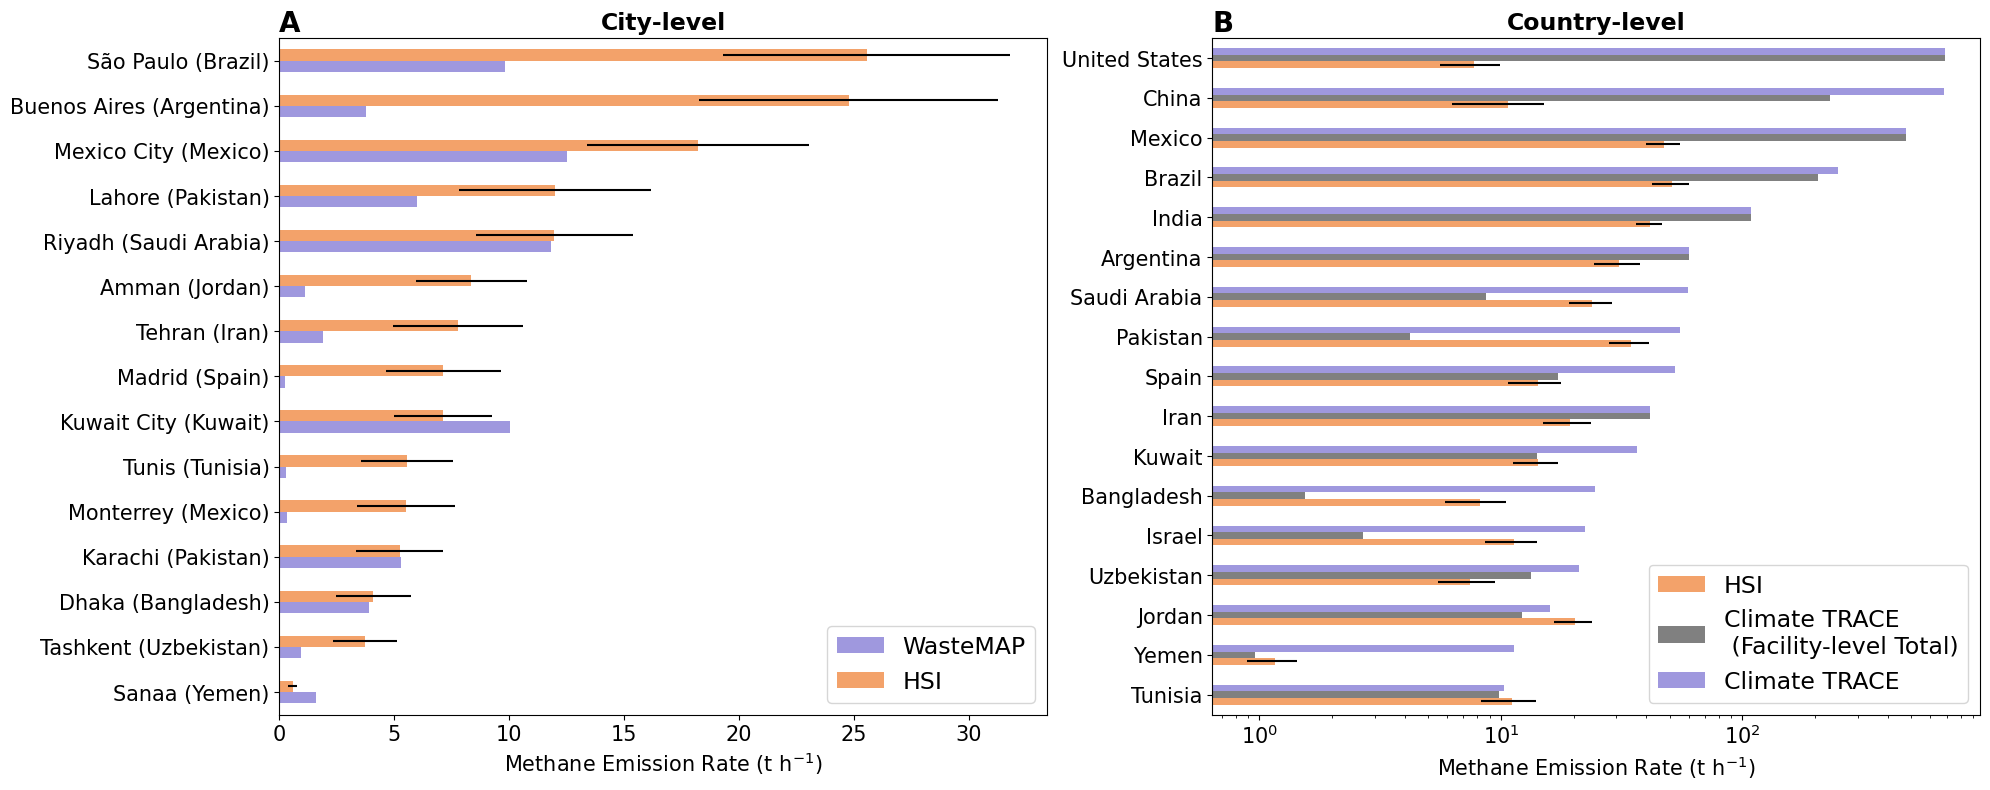

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

axs = axs.flatten()

ax = axs[0]

# sort by HSI emission
df_city_subset_sort = df_city_subset.sort_values('HSI')
# set city name
df_city_subset_sort['City'] = df_city_subset_sort['City'] + ' (' + df_city_subset_sort['Country'] + ')'

df_city_subset_sort.plot(ax=ax,
                        x='City', y=['WasteMAP', 'HSI'],
                        xerr=[[0]*len(df_city_subset),
                        df_city_subset_sort['HSI uncertainty'],      
                              ],
                        kind="barh",
                        color=['#9f98de', '#f3a26a']
                        )
ax.set_title('City-level')
ax.set_ylabel('')
ax.set_xlabel('Methane Emission Rate (t h$^{-1}$)')


ax = axs[1]

df_country_sort = df_country.dropna(subset=['HSI', 'ClimateTrace']).sort_values('ClimateTrace')\
                            .rename(columns={'ClimateTrace': 'Climate TRACE',
                                             'ClimateTrace_total': 'Climate TRACE \n (Facility-level Total)'})

df_country_sort.plot(ax=ax,
                        x='country',
                        y=['HSI', 'Climate TRACE \n (Facility-level Total)', 'Climate TRACE'],
                        xerr=[df_country_sort['HSI uncertainty'], 
                              [0]*len(df_country_sort),
                              [0]*len(df_country_sort),
                                   
                              ],
                        kind="barh",
                        color=['#f3a26a', 'gray', '#9f98de']
                        )

ax.set_xscale('log')
ax.set_title('Country-level')
ax.set_ylabel('')
ax.set_xlabel('Methane Emission Rate (t h$^{-1}$)')


for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.01, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_comp_city.pdf')

## OBS

In [36]:
df_merge_obs = df_obs.merge(df_merge[['name', 'emission', 'emission_uncertainty(%)', 'emission_uncertainty(t/h)']], on='name', how='left')

# keep landfills which have both HSI and OBS
df_merge_obs_nonan = df_merge_obs.dropna(subset=['emission_obs', 'emission', 'uncertainty_obs']).reset_index(drop=True)

In [37]:
df_merge_obs_nonan

,country,name,latitude,longitude,emission(t/h),uncertainty(t/h),year,source,Reference,emission_obs,uncertainty_obs,emission,emission_uncertainty(%),emission_uncertainty(t/h)
0,Argentina,Norte III,-34.529123,-58.622229,21.900000,7.800000,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,21.900000,7.800000,22.011851,29.227634,6.433543
1,India,Ghazipur,28.623779,77.327769,1.600000,1.100000,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,1.600000,1.100000,3.964033,33.654707,1.334084
2,India,Kanjurmarg,19.123219,72.953469,6.400000,4.000000,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,6.400000,4.000000,8.321277,32.185834,2.678272
3,Iran,Tehran,35.458738,51.330033,5.000000,1.000000,2022,EMIT,https://doi.org/10.1126/sciadv.adh2391,5.000000,1.000000,7.781694,36.458250,2.837069
4,Pakistan,Lakhodair,31.625742,74.417881,7.100000,3.100000,2020,GHGSat,https://doi.org/10.1126/sciadv.abn9683,7.100000,3.100000,12.003628,34.845901,4.182772
5,Spain,Pinto,40.258962,-3.635696,6.570000,0.930000,2018,In-situ,https://doi.org/10.5194/acp-22-295-2022,6.570000,0.930000,7.139583,35.011807,2.499697
6,United States,Charlotte Motor Speedway,35.339296,-80.658488,2.911990,0.984920,2022,AVIRIS-NG,CarbonMapper,2.911990,0.984920,4.850443,41.802398,2.027601
7,United States,Seminole Road,33.662314,-84.257714,2.913801,1.056978,2022,ASU GAO,CarbonMapper,2.913801,1.056978,2.892554,26.475571,0.765820


In [38]:
# df_merge_obs_nonan['emission_uncertainty(t/h)'] = df_merge_obs_nonan['emission'] * df_merge_obs_nonan['emission_uncertainty(%)'] *1e-2

df_merge_obs_nonan_format = df_merge_obs_nonan.round(decimals=1)
df_merge_obs_nonan_format['emission'] = df_merge_obs_nonan_format['emission'].astype(str) + ' $\pm$ ' + df_merge_obs_nonan_format['emission_uncertainty(t/h)'].astype(str)
df_merge_obs_nonan_format['emission_obs'] = df_merge_obs_nonan_format['emission_obs'].astype(str) + ' $\pm$ ' + df_merge_obs_nonan_format['uncertainty_obs'].astype(str)
df_merge_obs_nonan_format['latitude'] = df_merge_obs_nonan['latitude'].round(4).astype(str)
df_merge_obs_nonan_format['longitude'] = df_merge_obs_nonan['longitude'].round(4).astype(str)

# # print latex table
print(df_merge_obs_nonan_format.rename(columns={'country': 'Country', 'name': 'Name', 'latitude': 'Latitude', 'longitude': 'Longitude',
                                    'emission': 'HSI (t h$^{-1}$)', 'emission_obs': 'OBS (t h$^{-1}$)',
                                    'year': 'OBS report year', 'source': 'OBS source'
                                    }
                                    )[['Country', 'Name', 'Latitude', 'Longitude', 'HSI (t h$^{-1}$)', 'OBS (t h$^{-1}$)',
                                       'OBS report year', 'OBS source',
                                    ]].fillna('-').to_latex(index=False, float_format=lambda x: '%10.1f' % x))

# print(df_merge_obs_nonan.rename(columns={'country': 'Country', 'name': 'Name', 'latitude': 'Latitude', 'longitude': 'Longitude',
#                                     'emission': 'HSI (t h$^{-1}$)', 'emission_uncertainty(t/h)': 'HSI uncertainty (t h$^{-1}$)',
#                                     'emission_obs': 'OBS (t h$^{-1}$)', 'uncertainty_obs': 'OBS uncertainty (t h$^{-1}$)',
#                                     'year': 'OBS report year', 'source': 'OBS source'
#                                     }
#                                     )[['Country', 'Name', 'Latitude', 'Longitude', 'HSI (t h$^{-1}$)', 'OBS (t h$^{-1}$)',
#                                        'HSI uncertainty (t h$^{-1}$)', 'OBS uncertainty (t h$^{-1}$)', 'OBS report year', 'OBS source',
#                                     ]].fillna('-').to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{llllllll}
\toprule
Country & Name & Latitude & Longitude & HSI (t h$^{-1}$) & OBS (t h$^{-1}$) & OBS report year & OBS source \\
\midrule
Argentina & Norte III & -34.5291 & -58.6222 & 22.0 $\pm$ 6.4 & 21.9 $\pm$ 7.8 & 2021 & GHGSat \\
India & Ghazipur & 28.6238 & 77.3278 & 4.0 $\pm$ 1.3 & 1.6 $\pm$ 1.1 & 2021 & GHGSat \\
India & Kanjurmarg & 19.1232 & 72.9535 & 8.3 $\pm$ 2.7 & 6.4 $\pm$ 4.0 & 2021 & GHGSat \\
Iran & Tehran & 35.4587 & 51.33 & 7.8 $\pm$ 2.8 & 5.0 $\pm$ 1.0 & 2022 & EMIT \\
Pakistan & Lakhodair & 31.6257 & 74.4179 & 12.0 $\pm$ 4.2 & 7.1 $\pm$ 3.1 & 2020 & GHGSat \\
Spain & Pinto & 40.259 & -3.6357 & 7.1 $\pm$ 2.5 & 6.6 $\pm$ 0.9 & 2018 & In-situ \\
United States & Charlotte Motor Speedway & 35.3393 & -80.6585 & 4.9 $\pm$ 2.0 & 2.9 $\pm$ 1.0 & 2022 & AVIRIS-NG \\
United States & Seminole Road & 33.6623 & -84.2577 & 2.9 $\pm$ 0.8 & 2.9 $\pm$ 1.1 & 2022 & ASU GAO \\
\bottomrule
\end{tabular}



## Climate Trace top 20 landfills

### Validate csv and excel files

In [39]:
def validate_name(df_emiss, df):
    csv_name = df_emiss['name'].drop_duplicates()
    excel_name = df['name'].drop_duplicates()
    name_valid = csv_name.isin(excel_name)
    if all(name_valid):
        print('All csv landfill names are in the excel file')
    else:
        print(csv_name[~name_valid], 'is not in the excel file')

def append_excel_data(row, df):
    count = df[df['name']==row['name']][f"plume({row['platform'].lower()})"].item()
    overpass = df[df['name']==row['name']][f"overpass({row['platform'].lower()})"].item()

    return int(count), int(overpass)

In [40]:
top20_dir = '../data/Hyper_ClimateTrace20/'

filelist = list(chain(*[glob(os.path.join(top20_dir, '**', '*csv'), recursive=True)]))

df_top20 = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)

df_top20['emission_uncertainty(%)'] = df_top20['emission_uncertainty']/df_top20['emission']*100
# convert units from kg/h to t/h
df_top20['emission_uncertainty'] /= 1e3
df_top20['emission'] /= 1e3

df_top20_emiss = df_top20.groupby(['country', 'name', 'platform'], as_index=False)\
    .agg({'plume_longitude':'mean', 'plume_latitude':'mean', 'emission':'mean',
          'emission_uncertainty(%)': 'mean', 'plume_id': 'count'})\
    .rename(columns={'plume_id': 'plume_count', 'emission_uncertainty':'emission_uncertainty(t/h)'})

# remove space at end
df_top20_emiss['name'] = df_top20_emiss['name'].str.strip()

In [41]:
validate_name(df_top20_emiss, df_hyper_top20)

All csv landfill names are in the excel file


In [42]:
df_top20_emiss['count'], df_top20_emiss['overpass'] = zip(*df_top20_emiss.apply(append_excel_data, args=(df_hyper_top20,), axis=1))

# this should be empty
df_top20_emiss.query('plume_count != count')

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass
7,Mexico,Relleno Sanitario Portezuelos,EMIT,-116.744326,32.408734,6.010881,39.097457,6,7,7


### Calculate mean emission and add Climate TRACE data

In [43]:
# assume 0 emission for no plume
df_top20_emiss['emission_mean'] = df_top20_emiss['emission']*df_top20_emiss['plume_count']/df_top20_emiss['overpass']
df_top20_emiss['emission_ratio'] = df_top20_emiss['emission_mean']/df_top20_emiss['emission']

In [44]:
df_top20_emiss

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass,emission_mean,emission_ratio
0,Chile,Loma Los Colorados,EMIT,-70.796158,-32.956992,10.653701,36.755384,2,2,2,10.653701,1.000000
1,China,West New Territories,EMIT,113.933134,22.418820,6.002456,40.143283,1,1,1,6.002456,1.000000
2,China,West New Territories,EnMAP,113.932698,22.419768,9.370822,32.299478,1,1,1,9.370822,1.000000
3,Greece,Fyli,EMIT,23.648863,38.074794,10.641803,49.067989,1,1,2,5.320901,0.500000
4,Iran,Tehran,EMIT,51.330151,35.458524,7.781694,36.458250,9,9,9,7.781694,1.000000
5,Jordan,Ghabawi,EMIT,36.188811,31.930161,8.358493,28.886960,14,14,14,8.358493,1.000000
6,Mexico,Los Laureles,PRISMA,-103.175072,20.546055,3.412648,39.723216,1,1,1,3.412648,1.000000
7,Mexico,Relleno Sanitario Portezuelos,EMIT,-116.744326,32.408734,6.010881,39.097457,6,7,7,5.152184,0.857143
8,Mexico,Relleno Sanitario Portezuelos,PRISMA,-116.747452,32.405941,8.554138,33.108025,1,1,1,8.554138,1.000000
9,Mexico,Relleno Sanitario Puebla,EMIT,-98.136843,18.982700,1.690303,41.330727,2,2,2,1.690303,1.000000


### Merge all data for TOP 20 landfills

In [45]:
df_merge_obs.columns

Index(['country', 'name', 'latitude', 'longitude', 'emission(t/h)',
       'uncertainty(t/h)', 'year', 'source', 'Reference', 'emission_obs',
       'uncertainty_obs', 'emission', 'emission_uncertainty(%)',
       'emission_uncertainty(t/h)'],
      dtype='object')

In [46]:
# merge HSI and OBS
df_merge_all = df_top20_emiss[['country', 'name', 'plume_longitude', 'plume_latitude', 'platform', 'emission_mean', 'emission_uncertainty(%)']]\
    .merge(df_merge_obs[['country', 'name', 'emission_obs', 'uncertainty_obs', 'emission', 'emission_uncertainty(%)']],
                     on=['country', 'name'], how='left')

# add climate trace 20
df_merge_all = df_merge_all.merge(df_climatetrace[['name', 'emissions_quantity']], on='name', how='left')

# merge HSI emission
df_merge_all['HSI'] = df_merge_all[['emission_mean', 'emission']].bfill(axis=1).iloc[:, 0]
# df_merge_all['emission_uncertainty(t/h)'] = df_merge_all[['emission_uncertainty(t/h)_x', 'emission_uncertainty(t/h)_y']].bfill(axis=1).iloc[:, 0]
df_merge_all['emission_uncertainty(%)'] = df_merge_all[['emission_uncertainty(%)_x', 'emission_uncertainty(%)_y']].bfill(axis=1).iloc[:, 0]
df_merge_all['emission_uncertainty(t/h)'] = df_merge_all['HSI'] * df_merge_all['emission_uncertainty(%)'] * 1e-2

# rename columns for plot
df_merge_all.rename(columns={'plume_latitude': 'Latitude', 'plume_longitude':'Longitude', 
                             'emissions_quantity': 'Climate TRACE', 'emission_obs': 'OBS',
                             'emission_uncertainty(t/h)': 'HSI uncertainty (t h$^{-1}$)',
                             'uncertainty_obs': 'OBS uncertainty',
                            },
                    inplace=True
                    )

# average HSI emissions of same landfill
df_merge_all = df_merge_all.groupby(['country', 'name'])[['Latitude', 'Longitude', 'Climate TRACE', 'HSI', 'HSI uncertainty (t h$^{-1}$)', 'OBS', 'OBS uncertainty']].mean().reset_index()

# sort by Climate TRACE emission data
df_merge_all = df_merge_all.sort_values('Climate TRACE', ascending=False).reset_index(drop=True)

# calculate and rename again for table
# df_merge_all['OBS uncertainty (%)'] = df_merge_all['OBS uncertainty']/df_merge_all['OBS']*100
df_merge_all.rename(columns={'country': 'Country', 'name': 'Name'}, inplace=True)

# modify name for xaxis
df_merge_all['xname'] = df_merge_all['Name'] + ' (' + df_merge_all['Country'] + ')'

In [47]:
df_merge_all

,Country,Name,Latitude,Longitude,Climate TRACE,HSI,HSI uncertainty (t h$^{-1}$),OBS,OBS uncertainty,xname
0,Iran,Tehran,35.458524,51.330151,20.455947,7.781694,2.837069,5.00000,1.000000,Tehran (Iran)
1,Mexico,Simeprodeso,25.871232,-100.299335,17.866376,5.508303,2.150186,NaN,NaN,Simeprodeso (Mexico)
2,Chile,Loma Los Colorados,-32.956992,-70.796158,11.830760,10.653701,3.915809,1.17555,0.307225,Loma Los Colorados (Chile)
3,Mexico,Los Laureles,20.546055,-103.175072,11.826663,3.412648,1.355613,NaN,NaN,Los Laureles (Mexico)
4,Greece,Fyli,38.074794,23.648863,10.184733,5.320901,2.610859,NaN,NaN,Fyli (Greece)
5,Mexico,Relleno Sanitario Portezuelos,32.407337,-116.745889,9.266826,6.853161,2.423239,NaN,NaN,Relleno Sanitario Portezuelos (Mexico)
6,China,West New Territories,22.419294,113.932916,8.553950,7.686639,2.718155,NaN,NaN,West New Territories (China)
7,Mexico,Relleno Sanitario Puebla,18.982700,-98.136843,7.794032,1.690303,0.698615,NaN,NaN,Relleno Sanitario Puebla (Mexico)
8,Jordan,Ghabawi,31.930161,36.188811,7.268989,8.358493,2.414515,NaN,NaN,Ghabawi (Jordan)


In [48]:
# print latex table
df_merge_all_format = df_merge_all.round(decimals=1).fillna('-')
df_merge_all_format['HSI'] = df_merge_all_format['HSI'].astype(str) + ' $\pm$ ' + df_merge_all_format['HSI uncertainty (t h$^{-1}$)'].astype(str)
df_merge_all_format['OBS'] = df_merge_all_format['OBS'].astype(str) + ' $\pm$ ' + df_merge_all_format['OBS uncertainty'].astype(str)

print(df_merge_all_format[['Country', 'Name', 'Latitude', 'Longitude', 'Climate TRACE',	'HSI', 'OBS']]\
    .rename(columns={'Climate TRACE': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'OBS': 'OBS (t h$^{-1}$)'})\
    .to_latex(index=False, float_format=lambda x: '%10.1f' % x))

# print(df_merge_all[['Country', 'Name', 'Climate TRACE',	'HSI', 'OBS', 'HSI uncertainty (t h$^{-1}$)', 'OBS uncertainty']].fillna('-')\
#     .rename(columns={'Climate TRACE': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'OBS': 'OBS (t h$^{-1}$)', 'OBS uncertainty': 'OBS uncertainty (t h$^{-1}$)'})\
#     .to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{llrrrll}
\toprule
Country & Name & Latitude & Longitude & Climate TRACE (t h$^{-1}$) & HSI (t h$^{-1}$) & OBS (t h$^{-1}$) \\
\midrule
Iran & Tehran &       35.5 &       51.3 &       20.5 & 7.8 $\pm$ 2.8 & 5.0 $\pm$ 1.0 \\
Mexico & Simeprodeso &       25.9 &     -100.3 &       17.9 & 5.5 $\pm$ 2.2 & - $\pm$ - \\
Chile & Loma Los Colorados &      -33.0 &      -70.8 &       11.8 & 10.7 $\pm$ 3.9 & 1.2 $\pm$ 0.3 \\
Mexico & Los Laureles &       20.5 &     -103.2 &       11.8 & 3.4 $\pm$ 1.4 & - $\pm$ - \\
Greece & Fyli &       38.1 &       23.6 &       10.2 & 5.3 $\pm$ 2.6 & - $\pm$ - \\
Mexico & Relleno Sanitario Portezuelos &       32.4 &     -116.7 &        9.3 & 6.9 $\pm$ 2.4 & - $\pm$ - \\
China & West New Territories &       22.4 &      113.9 &        8.6 & 7.7 $\pm$ 2.7 & - $\pm$ - \\
Mexico & Relleno Sanitario Puebla &       19.0 &      -98.1 &        7.8 & 1.7 $\pm$ 0.7 & - $\pm$ - \\
Jordan & Ghabawi &       31.9 &       36.2 &        7.3 & 8.4 $\pm$ 2.4 & - $\pm

## Combination into one plot

In [49]:
def fit_line(x, y, type='ODR', sx=None, sy=None):
    if type == 'OLS':
        # ---- OLS ------
        # Reshape the arrays to 2D
        x_2d = x.reshape(-1, 1)
        y_2d = y.reshape(-1, 1)

        # Create and fit the linear regression model
        model = LinearRegression(fit_intercept=False)
        model.fit(x_2d, y_2d)

        # Get the slope of the linear regression line
        slope = model.coef_[0][0]
        print(model.intercept_)

        # Calculate R-squared
        r_squared = model.score(x_2d, y_2d)
    elif type == 'RMA':
        # ---- RMA ------
        from pylr2 import regress2

        results = regress2(x, y, _method_type_2="reduced major axis", _need_intercept=False)
        slope = results['slope']
        y_pred = results['predict']
        y_mean = y.mean()
        SSregression = ((y_pred - y_mean) ** 2).sum()
        SStotal = ((y - y_mean) ** 2).sum()
        r_squared = SSregression / SStotal
    elif type == 'ODR':
        import scipy.odr as odr

        # Define the linear function
        def linear_function(B, x):
            return B[0] * x #+ B[1]

        # Create a model
        linear_model = odr.Model(linear_function)

        # Create a RealData object with errors
        data = odr.RealData(x, y, sx=sx, sy=sy)

        # Set up ODR with the model and data
        # guess the initial via OLS
        # Reshape the arrays to 2D
        x_2d = x.reshape(-1, 1)
        y_2d = y.reshape(-1, 1)

        # Create and fit the linear regression model
        model = LinearRegression(fit_intercept=False)
        model.fit(x_2d, y_2d)

        # Get the slope of the linear regression line
        odr_instance = odr.ODR(data, linear_model, beta0=[model.coef_[0][0]])

        # Run the regression
        output = odr_instance.run()

        # Extract the parameter
        slope = output.beta[0]
        slope_err = output.sd_beta[0]
        print('ODR slope err: ', slope_err)

        y_pred = linear_function(output.beta, x)
        y_mean = y.mean()
        SSregression = ((y_pred - y_mean) ** 2).sum()
        SStotal = ((y - y_mean) ** 2).sum()
        r_squared = SSregression / SStotal

    return slope, r_squared

In [50]:
df_merge_obs_nonan['type'] = 'Satellite'
df_merge_obs_nonan.loc[df_merge_obs_nonan.source.isin(['AVIRIS-NG', 'ASU GAO']), 'type'] = 'Aircraft'
df_merge_obs_nonan.loc[df_merge_obs_nonan.source=='In-situ', 'type'] = 'In-situ'

In [51]:
# # ------------ Gg yr-1 ------------
# fig, axs = plt.subplots(figsize=(8, 17), nrows=2)

# axs = axs.flatten()

# ax = axs[0]
# l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='k')

# # ---- HSI v.s. Climate TRACE ---
# x = df_merge_ct['HSI'].values
# xerr = x * df_merge_ct['HSI uncertainty (%)'] *1e-2
# y = df_merge_ct['Climate TRACE'].values

# slope, r_squared = fit_line(x, y)

# # l2 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0', linestyle='--')
# # l2 = ax.axline(xy1=(0, 0), slope=slope, label='Climate TRACE', c='C0', linestyle='--')
# ax.plot(range(300), slope*range(300), label='Climate TRACE', c='darkgray', linestyle='--', dashes=(3, 3), linewidth=3)

# # ax.scatter(x, y)
# ax.errorbar(x, y, xerr=xerr, c='darkgray', fmt='o', capsize=3, markersize=4, elinewidth=0.6)

# # ---- HSI v.s. OBS ---
# x = df_merge_obs_nonan['emission'].values
# xerr = x * df_merge_obs_nonan['emission_uncertainty(%)'] *1e-2
# y = df_merge_obs_nonan['emission_obs'].values
# yerr = df_merge_obs_nonan['uncertainty_obs'].values

# # import statsmodels.formula.api as smf
# # model = smf.ols('y~ x - 1', data={'x': x, 'y': y}).fit()
# # slope = model.params['x']
# # rsquared = model.rsquared

# slope, r_squared = fit_line(x, y)
# print('HSI v.s. OBS, slope: ', slope, 'R2: ', r_squared)
# # l3 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='darkorange', linestyle='--')
# # l3 = ax.axline(xy1=(0, 0), slope=slope, label='OBS', c='darkorange', linestyle='--')
# ax.plot(range(300), slope*range(300), label='OBS', c='#f3a26a', linestyle='--', dashes=(3, 3), linewidth=3)
# ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, markersize=4, elinewidth=0.6, c='#f3a26a')

# # plot scatter
# # def dfScatter(df, ax, xcol='emission', ycol='emission_obs', catcol='type'):
# #     categories = np.unique(df[catcol])
# #     colors = np.linspace(0, 1, len(categories))
# #     colordict = dict(zip(categories, colors))  

# #     df["Color"] = df[catcol].apply(lambda x: colordict[x])
# #     ax.scatter(df[xcol], df[ycol], c=df.Color, cmap='viridis', s=4, zorder=10)

# # dfScatter(df_merge_obs_nonan, ax)

# ax.set_xlabel('HSI Estimation (Gg yr$^{-1}$)')
# ax.set_ylabel('CH$_4$ Emission Rate (Gg yr$^{-1}$)')

# ax.legend(loc='upper left')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1, 300)
# ax.set_ylim(1, 300)

# # ---- TOP 20 Climate Trace ----
# ax = axs[1]

# df_merge_all.plot(ax=ax,
#                 x='xname', y=['Climate TRACE', 'HSI', 'OBS'],
#                 yerr=[[0]*len(df_merge_all),
#                         df_merge_all['HSI']*df_merge_all['HSI uncertainty (%)']*1e-2,
#                         df_merge_all['OBS uncertainty'],
#                         ],
#                 kind="bar",
#                 # color=['darkgrey', 'C0', 'darkorange'],
#                 color=['darkgray', '#9f98de', '#f3a26a'],
#                 rot=90,
#                 )
# ax.set_xlabel('')
# ax.set_ylabel('CH$_4$ Emission Rate (Gg yr$^{-1}$)')
# ax.set_ylim(ymin=0)

# for n, ax in enumerate(axs):
#     # plot wind quivers
#     ax.text(0, 1.05, string.ascii_uppercase[n],
#             transform=ax.transAxes, 
#             size=20, weight='bold')

# fig.tight_layout()
# # fig.savefig('../figures/emission_comp.pdf')

In [52]:
df_merge_obs_nonan

,country,name,latitude,longitude,emission(t/h),uncertainty(t/h),year,source,Reference,emission_obs,uncertainty_obs,emission,emission_uncertainty(%),emission_uncertainty(t/h),type
0,Argentina,Norte III,-34.529123,-58.622229,21.900000,7.800000,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,21.900000,7.800000,22.011851,29.227634,6.433543,Satellite
1,India,Ghazipur,28.623779,77.327769,1.600000,1.100000,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,1.600000,1.100000,3.964033,33.654707,1.334084,Satellite
2,India,Kanjurmarg,19.123219,72.953469,6.400000,4.000000,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,6.400000,4.000000,8.321277,32.185834,2.678272,Satellite
3,Iran,Tehran,35.458738,51.330033,5.000000,1.000000,2022,EMIT,https://doi.org/10.1126/sciadv.adh2391,5.000000,1.000000,7.781694,36.458250,2.837069,Satellite
4,Pakistan,Lakhodair,31.625742,74.417881,7.100000,3.100000,2020,GHGSat,https://doi.org/10.1126/sciadv.abn9683,7.100000,3.100000,12.003628,34.845901,4.182772,Satellite
5,Spain,Pinto,40.258962,-3.635696,6.570000,0.930000,2018,In-situ,https://doi.org/10.5194/acp-22-295-2022,6.570000,0.930000,7.139583,35.011807,2.499697,In-situ
6,United States,Charlotte Motor Speedway,35.339296,-80.658488,2.911990,0.984920,2022,AVIRIS-NG,CarbonMapper,2.911990,0.984920,4.850443,41.802398,2.027601,Aircraft
7,United States,Seminole Road,33.662314,-84.257714,2.913801,1.056978,2022,ASU GAO,CarbonMapper,2.913801,1.056978,2.892554,26.475571,0.765820,Aircraft


0.0
HSI v.s. Climate TRACE, slope:  0.6111676350720061 Pearson correlation:  0.18007551552111714 MBE:  -2.412200142933648 RMSE:  6.2977238023573
0.0
HSI v.s. Climate TRACE, slope:  0.5112250259939956 Pearson correlation:  0.07432294154572286 MBE:  -2.805846839886587 RMSE:  5.665178832183017


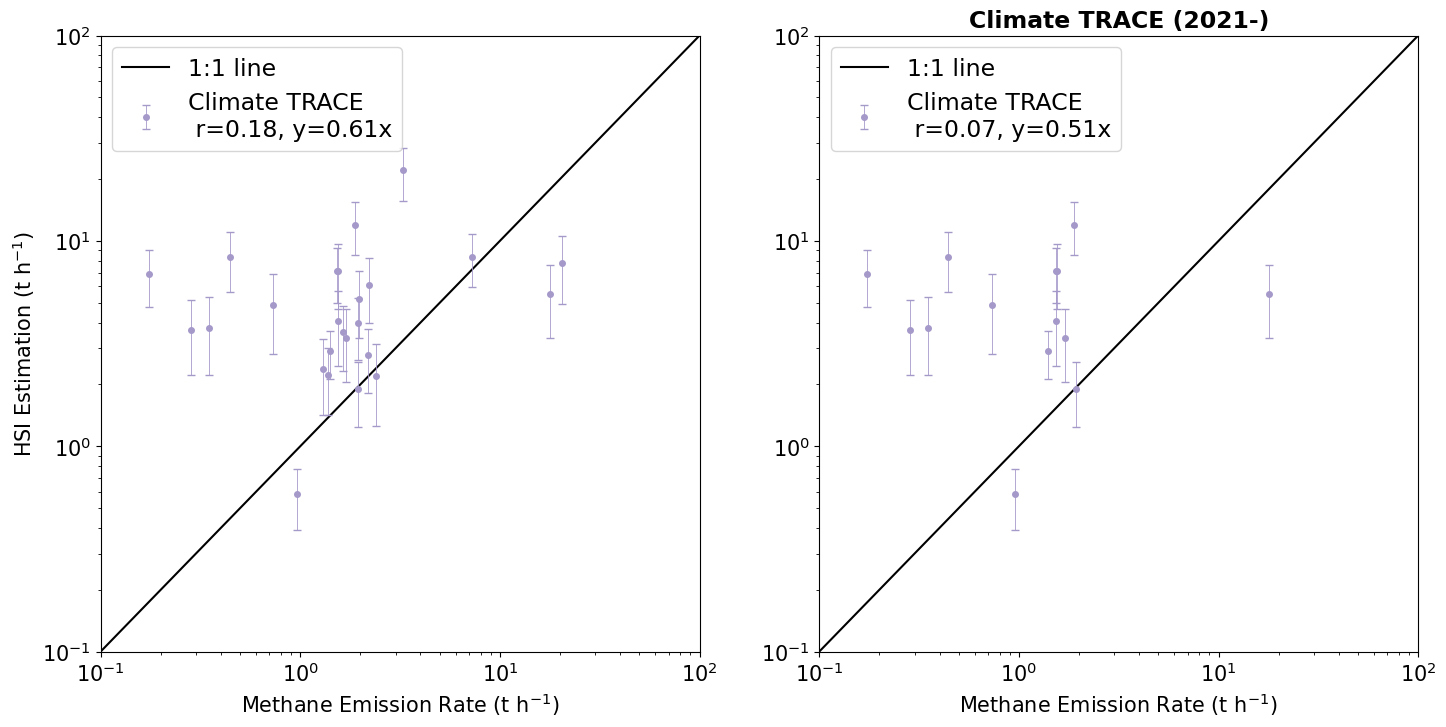

In [53]:
fig, axs = plt.subplots(figsize=(17, 8), ncols=2)

axs = axs.flatten()

ax = axs[0]
l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='k')

# ---- HSI v.s. Climate TRACE ---
y = df_merge_ct['HSI'].values # t/h
yerr = df_merge_ct['HSI uncertainty (t h$^{-1}$)']
x = df_merge_ct['Climate TRACE'].values  # t/h

slope_CT, r_squared = fit_line(x, y, type='OLS')
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
mbe = (x-y).mean()
rmse = mean_squared_error(x, y, squared=False)
corr_CT, _ = pearsonr(x, y)
print('HSI v.s. Climate TRACE, slope: ', slope_CT, 'Pearson correlation: ', corr_CT, 'MBE: ', mbe, 'RMSE: ', rmse)

ax.errorbar(x, y, yerr=yerr, c='#A599CA', fmt='o', capsize=3,
            markersize=4, elinewidth=0.6, label=f'Climate TRACE \n r={np.round(corr_CT, 2)}, y={np.round(slope_CT, 2)}x')
ax.legend(loc='upper left')
ax.set_ylabel('HSI Estimation (t h$^{-1}$)')

# ---- HSI v.s. Climate TRACE (2021-) ---
ax = axs[1]
l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='k')
y = df_2021_2022['HSI'].values # t/h
yerr = df_2021_2022['HSI uncertainty (t h$^{-1}$)']
x = df_2021_2022['Climate TRACE'].values  # t/h

slope_CT, r_squared = fit_line(x, y, type='OLS')
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
mbe = (x-y).mean()
rmse = mean_squared_error(x, y, squared=False)
corr_CT, _ = pearsonr(x, y)
print('HSI v.s. Climate TRACE, slope: ', slope_CT, 'Pearson correlation: ', corr_CT, 'MBE: ', mbe, 'RMSE: ', rmse)

ax.errorbar(x, y, yerr=yerr, c='#A599CA', fmt='o', capsize=3,
            markersize=4, elinewidth=0.6, label=f'Climate TRACE \n r={np.round(corr_CT, 2)}, y={np.round(slope_CT, 2)}x')
ax.set_title('Climate TRACE (2021-)')

ax.legend(loc='upper left')

for ax in axs:
    ax.set_xlabel('Methane Emission Rate (t h$^{-1}$)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.1, 100)
    ax.set_ylim(0.1, 100)

In [54]:
df_merge_ct

,Country,Name,HSI,Climate TRACE,HSI uncertainty (t h$^{-1}$),plume_count,Report Source,Report Year,HSI/ClimateTRACE
0,Argentina,González Catán,2.769783,2.177970,0.944760,5,Waste Atlas,2013,1.3
1,Argentina,Norte III,22.011851,3.256637,6.433543,8,Waste Atlas,2013,6.8
2,Argentina,Piedra Blanca,3.347987,1.701192,1.300190,2,METER/OSM,2022,2.0
3,Bangladesh,Aminbazar,4.092617,1.541889,1.629317,1,METER/OSM,2022,2.7
7,India,Bandhwari,2.397993,0.015812,0.823099,4,Global Plastic Watch,2021,151.7
8,India,Bhalswa,2.214972,1.377097,0.795131,6,Waste Atlas,2013,1.6
9,India,Deonar,2.199969,2.400635,0.944221,2,Waste Atlas,2013,0.9
10,India,Ghazipur,3.964033,1.956334,1.334084,9,Waste Atlas,2013,2.0
11,India,Kachara,3.760001,0.349474,1.542553,1,Global Plastic Watch,2021,10.8
12,India,Kanjurmarg,8.321277,0.442059,2.678272,4,Global Plastic Watch,2021,18.8


In [55]:
import plotly.express as px

fig = px.scatter(df_merge_ct, x="Climate TRACE", y="HSI", #color="species",
                 # size='petal_length',
                 hover_data=['Country', 'Name', 'plume_count', 'Report Source',	'Report Year'],
                 log_x=True, log_y=True
                )

In [56]:
fig.update_layout(width=600, height=600, yaxis_range=[-1, 1.2], xaxis_range=[-1, 1.2])
fig.show()

In [57]:
(df_merge_obs_nonan['emission'] / df_merge_obs_nonan['emission_obs']).median()

1.4282691359038235

0.0
HSI v.s. Climate TRACE, slope:  0.6111676350720061 Pearson correlation:  0.18007551552111714 MBE:  -2.412200142933648 RMSE:  6.2977238023573
ODR slope err:  0.13520803582647667
HSI v.s. OBS, slope:  1.3142568784242106 R2:  1.9036930965881598 Pearson correlation:  0.967319499769832 MBE:  -1.8211589570490543 RMSE:  2.37587708060694


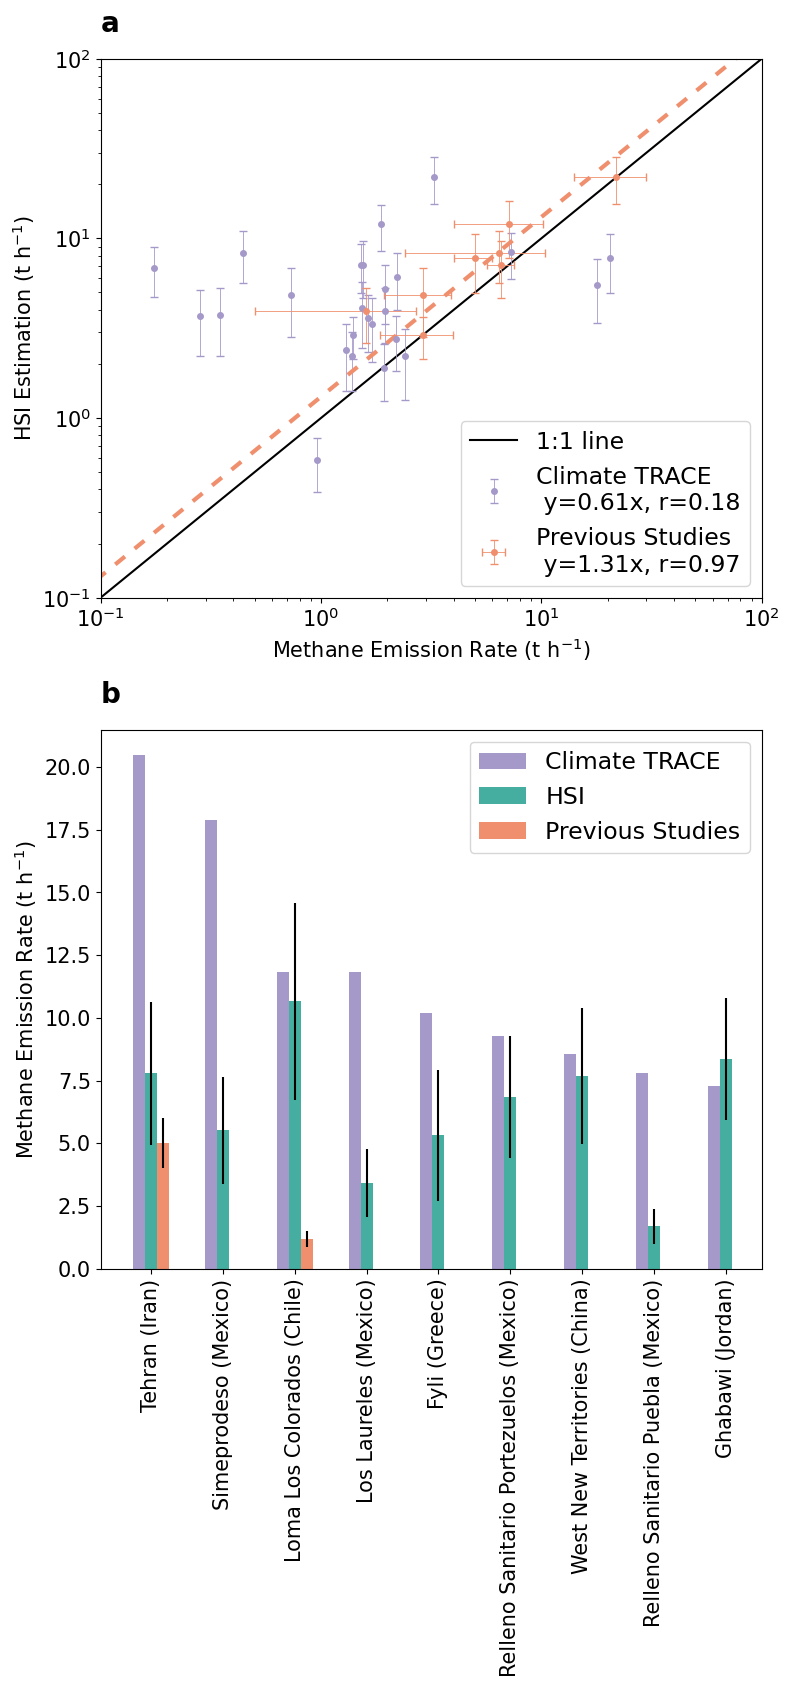

In [58]:
fig, axs = plt.subplots(figsize=(8, 17), nrows=2)

axs = axs.flatten()

ax = axs[0]
l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='k')

# ---- HSI v.s. Climate TRACE ---
y = df_merge_ct['HSI'].values # t/h
yerr = df_merge_ct['HSI uncertainty (t h$^{-1}$)']
x = df_merge_ct['Climate TRACE'].values  # t/h

slope_CT, r_squared = fit_line(x, y, type='OLS')
# slope_CT, r_squared = fit_line(x, y, sx=xerr, type='ODR')
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
mbe = (x-y).mean()
rmse = mean_squared_error(x, y, squared=False)
corr_CT, _ = pearsonr(x, y)
print('HSI v.s. Climate TRACE, slope: ', slope_CT, 'Pearson correlation: ', corr_CT, 'MBE: ', mbe, 'RMSE: ', rmse)

# l2 = ax.axline(xy1=(0, 0), slope=slope_CT, label=f'y = {slope_CT:.1f}x (R$^2$ = {r_squared:.2f})', c='C0', linestyle='--')
# l2 = ax.axline(xy1=(0, 0), slope=slope_CT, label='Climate TRACE', c='C0', linestyle='--')
# ax.plot(np.arange(300), slope_CT*np.arange(300), label='Climate TRACE', c='#A599CA', linestyle='--', dashes=(3, 3), linewidth=3)

# ax.scatter(x, y)
ax.errorbar(x, y, yerr=yerr, c='#A599CA', fmt='o', capsize=3,
            markersize=4, elinewidth=0.6, label=f'Climate TRACE \n y={np.round(slope_CT, 2)}x, r={np.round(corr_CT, 2)}')

# ---- HSI v.s. OBS ---
y = df_merge_obs_nonan['emission'].values  # t/h
yerr = y * df_merge_obs_nonan['emission_uncertainty(%)'].values * 1e-2
x = df_merge_obs_nonan['emission_obs'].values  # t/h
xerr = df_merge_obs_nonan['uncertainty_obs'].fillna(1).values  # t/h

# import statsmodels.formula.api as smf
# model = smf.ols('y~ x - 1', data={'x': x, 'y': y}).fit()
# slope = model.params['x']
# rsquared = model.rsquared

# slope, r_squared = fit_line(x, y, type='RMA')
slope_OBS, r_squared = fit_line(x, y, sx=xerr, sy=yerr, type='ODR')
corr_OBS, _ = pearsonr(x, y)
mbe = (x-y).mean()
rmse = mean_squared_error(x, y, squared=False)
print('HSI v.s. OBS, slope: ', slope_OBS, 'R2: ', r_squared, 'Pearson correlation: ', corr_OBS, 'MBE: ', mbe, 'RMSE: ', rmse)
# l3 = ax.axline(xy1=(0, 0), slope=slope_OBS, label=f'y = {slope_OBS:.1f}x (R$^2$ = {r_squared:.2f})', c='darkorange', linestyle='--')
# l3 = ax.axline(xy1=(0, 0), slope=slope_OBS, label='OBS', c='darkorange', linestyle='--')
l3 = ax.plot(np.arange(300), slope_OBS*np.arange(300), c='#F08F6E', linestyle='--', dashes=(3, 3), linewidth=3)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3,
            markersize=4, elinewidth=0.6, c='#F08F6E',
            label=f'Previous Studies \n y={np.round(slope_OBS, 2)}x, r={np.round(corr_OBS, 2)}'
            )

# # plot scatter
# def dfScatter(df, ax, xcol='emission', ycol='emission_obs', catcol='type'):
#     categories = np.unique(df[catcol])
#     colors = np.linspace(0, 1, len(categories))
#     colordict = dict(zip(categories, colors))  

#     df["Color"] = df[catcol].apply(lambda x: colordict[x])
#     ax.scatter(df[xcol], df[ycol], c=df.Color, cmap='viridis', s=4, zorder=10)

# dfScatter(df_merge_obs_nonan, ax)

ax.set_ylabel('HSI Estimation (t h$^{-1}$)')
ax.set_xlabel('Methane Emission Rate (t h$^{-1}$)')

ax.legend(loc='lower right')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 100)
ax.set_ylim(0.1, 100)
# ax.set_xlim(0, 30)
# ax.set_ylim(0, 30)

# ---- TOP 20 Climate Trace ----
ax = axs[1]

df_merge_all.rename(columns={'OBS': 'Previous Studies'}).plot(ax=ax,
                x='xname', y=['Climate TRACE', 'HSI', 'Previous Studies'],
                yerr=[[0]*len(df_merge_all),
                      df_merge_all['HSI uncertainty (t h$^{-1}$)'],
                        df_merge_all['OBS uncertainty'],
                        ],
                kind="bar",
                # color=['darkgrey', 'C0', 'darkorange'],
                color=['#A599CA', '#46AEA0', '#F08F6E'],
                rot=90,
                )
ax.set_xlabel('')
ax.set_ylabel('Methane Emission Rate (t h$^{-1}$)')
ax.set_xlim(xmin=-0.7)

for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.05, string.ascii_lowercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_comp.pdf', bbox_inches='tight', pad_inches=0)

In [59]:
df_merge_all

,Country,Name,Latitude,Longitude,Climate TRACE,HSI,HSI uncertainty (t h$^{-1}$),OBS,OBS uncertainty,xname
0,Iran,Tehran,35.458524,51.330151,20.455947,7.781694,2.837069,5.00000,1.000000,Tehran (Iran)
1,Mexico,Simeprodeso,25.871232,-100.299335,17.866376,5.508303,2.150186,NaN,NaN,Simeprodeso (Mexico)
2,Chile,Loma Los Colorados,-32.956992,-70.796158,11.830760,10.653701,3.915809,1.17555,0.307225,Loma Los Colorados (Chile)
3,Mexico,Los Laureles,20.546055,-103.175072,11.826663,3.412648,1.355613,NaN,NaN,Los Laureles (Mexico)
4,Greece,Fyli,38.074794,23.648863,10.184733,5.320901,2.610859,NaN,NaN,Fyli (Greece)
5,Mexico,Relleno Sanitario Portezuelos,32.407337,-116.745889,9.266826,6.853161,2.423239,NaN,NaN,Relleno Sanitario Portezuelos (Mexico)
6,China,West New Territories,22.419294,113.932916,8.553950,7.686639,2.718155,NaN,NaN,West New Territories (China)
7,Mexico,Relleno Sanitario Puebla,18.982700,-98.136843,7.794032,1.690303,0.698615,NaN,NaN,Relleno Sanitario Puebla (Mexico)
8,Jordan,Ghabawi,31.930161,36.188811,7.268989,8.358493,2.414515,NaN,NaN,Ghabawi (Jordan)


(0.0, 21.4787448630137)

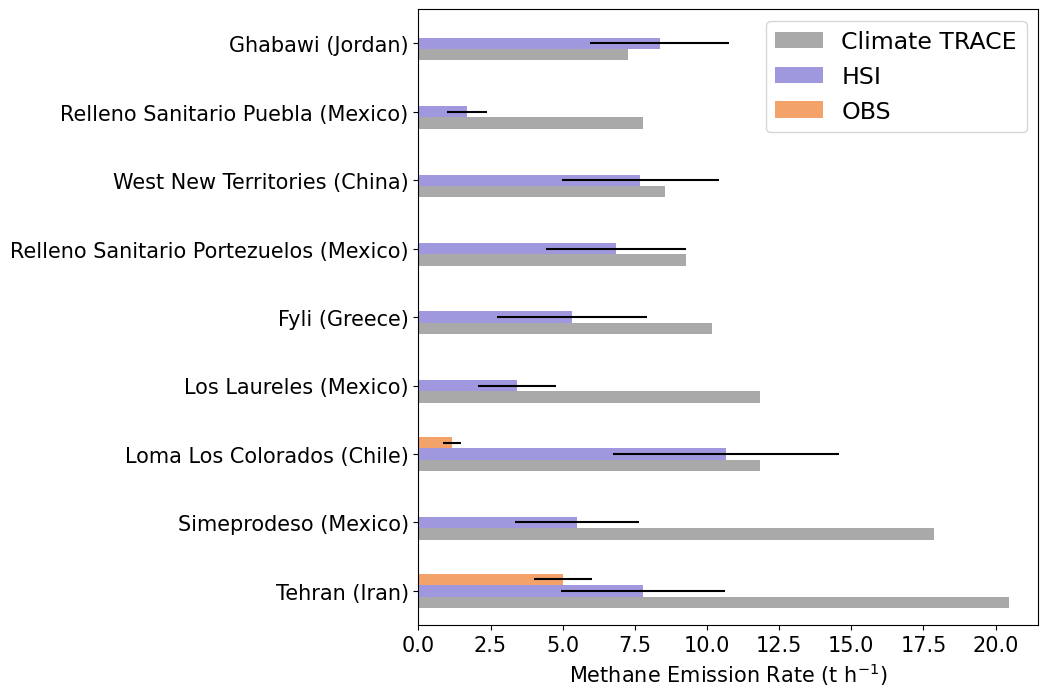

In [60]:
# for ppt
fig, ax = plt.subplots(figsize=(8, 8))
df_merge_all.plot(ax=ax,
                x='xname', y=['Climate TRACE', 'HSI', 'OBS'],
                xerr=[[0]*len(df_merge_all),
                      df_merge_all['HSI uncertainty (t h$^{-1}$)'],
                        df_merge_all['OBS uncertainty'],
                        ],
                kind="barh",
                # color=['darkgrey', 'C0', 'darkorange'],
                color=['darkgray', '#9f98de', '#f3a26a'],
                # rot=90,
                )
ax.set_ylabel('')
ax.set_xlabel('Methane Emission Rate (t h$^{-1}$)')
ax.set_xlim(xmin=0)

In [61]:
# Mean bias and RMSE for landfill hotspot comparison
bias = np.mean(df_merge_obs_nonan['emission'] - df_merge_obs_nonan['emission_obs'])
rmse = mean_squared_error(y_true=df_merge_obs_nonan['emission_obs'], y_pred=df_merge_obs_nonan['emission'], squared=False)
print('Mean bias: ', bias, 'RMSE: ', rmse)

Mean bias:  1.8211589570490543 RMSE:  2.37587708060694


In [62]:
df_merge_all['hsi_ct_diff_percent'] = (df_merge_all['HSI'] - df_merge_all['Climate TRACE'])/df_merge_all['Climate TRACE']*1e2

In [63]:
df_merge_all

,Country,Name,Latitude,Longitude,Climate TRACE,HSI,HSI uncertainty (t h$^{-1}$),OBS,OBS uncertainty,xname,hsi_ct_diff_percent
0,Iran,Tehran,35.458524,51.330151,20.455947,7.781694,2.837069,5.00000,1.000000,Tehran (Iran),-61.958770
1,Mexico,Simeprodeso,25.871232,-100.299335,17.866376,5.508303,2.150186,NaN,NaN,Simeprodeso (Mexico),-69.169445
2,Chile,Loma Los Colorados,-32.956992,-70.796158,11.830760,10.653701,3.915809,1.17555,0.307225,Loma Los Colorados (Chile),-9.949143
3,Mexico,Los Laureles,20.546055,-103.175072,11.826663,3.412648,1.355613,NaN,NaN,Los Laureles (Mexico),-71.144460
4,Greece,Fyli,38.074794,23.648863,10.184733,5.320901,2.610859,NaN,NaN,Fyli (Greece),-47.756103
5,Mexico,Relleno Sanitario Portezuelos,32.407337,-116.745889,9.266826,6.853161,2.423239,NaN,NaN,Relleno Sanitario Portezuelos (Mexico),-26.046303
6,China,West New Territories,22.419294,113.932916,8.553950,7.686639,2.718155,NaN,NaN,West New Territories (China),-10.139303
7,Mexico,Relleno Sanitario Puebla,18.982700,-98.136843,7.794032,1.690303,0.698615,NaN,NaN,Relleno Sanitario Puebla (Mexico),-78.312849
8,Jordan,Ghabawi,31.930161,36.188811,7.268989,8.358493,2.414515,NaN,NaN,Ghabawi (Jordan),14.988392


In [64]:
da_Loma_Los_Colorados = df_merge_all[df_merge_all['Name'] == 'Loma Los Colorados']

(da_Loma_Los_Colorados['OBS']-da_Loma_Los_Colorados['HSI'])/da_Loma_Los_Colorados['HSI'], (da_Loma_Los_Colorados['OBS']-da_Loma_Los_Colorados['Climate TRACE'])/da_Loma_Los_Colorados['Climate TRACE']
# (1.18-11.830760)/11.830760

(2   -0.889658
 dtype: float64,
 2   -0.900636
 dtype: float64)